In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.palettes import Spectral4, Spectral6, Spectral8, Spectral11 #color palette
import calendar

output_notebook()

colorRange = Spectral8

%matplotlib inline
sns.set(color_codes=True)

Loading BokehJS ...

# Open and prepare dataset

In [45]:
data = pd.read_excel("cykeltaellinger-2014.xlsx", header=10)
data.head()

,Vej-Id,Vejnavn,Spor,(UTM32),(UTM32).1,Dato,kl.00-01,kl.01-02,kl.02-03,kl.03-04,...,kl.14-15,kl.15-16,kl.16-17,kl.17-18,kl.18-19,kl.19-20,kl.20-21,kl.21-22,kl.22-23,kl.23-24
0,101 1011492-0 1/ 1 -,Ellebjergvej,NaN,720887,6172775,01.01.2014,5,3,2,6,...,3,5,13,1,0,3,3,2,0,2
1,101 1011492-0 1/ 1 -,Ellebjergvej,NaN,720887,6172775,02.01.2014,1,1,1,0,...,13,10,17,14,3,4,9,3,1,1
2,101 1011492-0 1/ 1 -,Ellebjergvej,NaN,720887,6172775,03.01.2014,0,0,0,3,...,30,8,11,4,5,6,2,6,0,2
3,101 1011492-0 1/ 1 -,Ellebjergvej,NaN,720887,6172775,04.01.2014,1,1,1,0,...,12,14,8,4,5,3,2,1,3,3
4,101 1011492-0 1/ 1 -,Ellebjergvej,NaN,720887,6172775,05.01.2014,0,1,2,0,...,5,10,3,12,7,3,5,3,4,1


In [46]:
#Rename columns in english and set up the index
data.columns =["Road ID", "Road name", "Track", "Coordinate X", "Coordinate Y", "Date", 'kl.00-01',
       'kl.01-02', 'kl.02-03', 'kl.03-04', 'kl.04-05', 'kl.05-06', 'kl.06-07',
       'kl.07-08', 'kl.08-09', 'kl.09-10', 'kl.10-11', 'kl.11-12', 'kl.12-13',
       'kl.13-14', 'kl.14-15', 'kl.15-16', 'kl.16-17', 'kl.17-18', 'kl.18-19',
       'kl.19-20', 'kl.20-21', 'kl.21-22', 'kl.22-23', 'kl.23-24']

data["Date"]=pd.to_datetime(data["Date"], format="%d.%m.%Y")

#Remove columns that we are not using
data.drop(["Road ID", "Track", "Coordinate X", "Coordinate Y"], axis=1, inplace=True)

In [47]:
# Rearrange the dataset in a better way so it is easier to use. one value per row for each road.
newdata = data.set_index(["Date", "Road name"]).stack().reset_index()
newdata["Hour"] = newdata.index.values % 24
newdata["Date"]= newdata["Date"] + pd.to_timedelta(newdata["Hour"] , unit='h')
newdata.drop(["Hour", "level_2"], axis=1, inplace=True)
data = newdata.pivot_table(0, "Date", "Road name" )

In [48]:
#Add some time features for the analysis
month_to_season_dct = {
    1: 'Winter', 2: 'Winter',
    3: 'Winter', 4: 'Spring', 5: 'Spring',
    6: 'Spring', 7: 'Summer', 8: 'Summer',
    9: 'Summer', 10: 'Autumn', 11: 'Autumn',
    12: 'Autumn'
}

listRoad = data.columns.values.tolist()
data["day"]=data.index.dayofyear
data["month"]=data.index.month
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data["Season"] = [month_to_season_dct[x] for x in data["month"]]
data.head()

Road name,Ellebjergvej,Fredensbro,Frederikssundsvej,Hareskovvej,Kalvebod Brygge,Roskildevej,Torvegade,Vigerslev Allé,Åboulevard,day,month,hour,weekday,Season
Date,,,,,,,,,,,,,,
2014-01-01 00:00:00,10.666667,3.666667,66.333333,4.000000,8.000000,0,217.000000,26.333333,59.666667,1,1,0,2,Winter
2014-01-01 01:00:00,7.000000,6.333333,86.000000,5.000000,2.333333,0,190.666667,27.666667,48.333333,1,1,1,2,Winter
2014-01-01 02:00:00,7.666667,5.333333,88.666667,4.666667,9.333333,0,187.666667,28.333333,65.000000,1,1,2,2,Winter
2014-01-01 03:00:00,5.666667,9.333333,62.333333,3.000000,11.666667,0,133.333333,28.000000,131.000000,1,1,3,2,Winter
2014-01-01 04:00:00,4.333333,15.000000,60.000000,0.666667,18.000000,0,125.000000,24.333333,159.000000,1,1,4,2,Winter


# Overview

In [49]:
#Data completeness
for road in listRoad:
    print(road + " dataset is " + '{:3.0f}'.format((1-np.count_nonzero(data[road].isnull())/data.shape[0])*100) +"% complete")

Ellebjergvej dataset is  84% complete
Fredensbro dataset is 100% complete
Frederikssundsvej dataset is 100% complete
Hareskovvej dataset is  72% complete
Kalvebod Brygge dataset is  41% complete
Roskildevej dataset is   3% complete
Torvegade dataset is 100% complete
Vigerslev Allé dataset is 100% complete
Åboulevard dataset is 100% complete


In [50]:
#Remove unrelevant columns
data.drop("Roskildevej", axis=1, inplace=True)
listRoad.remove("Roskildevej")
data.fillna(0, inplace=True)

# Overview: weekly pattern, Kalvebod Brygge was closed or the meter was not logging properly.

In [51]:
yearPerDay = data.groupby("day").sum()

plot2 = figure(width=1000, height=600)
plot2.background_fill_color = "whitesmoke"

plot2.xaxis.axis_label="Day"
plot2.yaxis.axis_label="Value"

xaxis = yearPerDay.index

for index, road in enumerate(listRoad):
    plot2.line(xaxis, yearPerDay[road], line_width=2, color=colorRange[index], legend=road)
    
show(plot2)

# 5 days weekly pattern showing that people use their bike to commute to work and in the afternoon during weekdays.  

In [70]:
weekByHour = data.groupby(["weekday", "hour"]).mean()

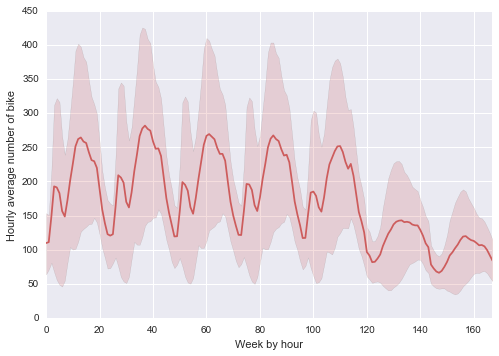

In [79]:
output = []

for road in listRoad:
    output.append(weekByHour[road].values)
    
sns.tsplot(data=output, color="indianred")
plt.xlabel('Week by hour')
plt.ylabel('Hourly average number of bike')

# As expected, there are more cyclists in Spring and Summer

In [129]:
hourBySeason = data.loc[:, ["Season", "hour", "Total"]].groupby(["Season", "hour"]).mean()
hourBySeason = hourBySeason.unstack(0)
hourBySeason.columns = hourBySeason.columns.droplevel(0)

plot2 = figure(width=1000, height=600)
plot2.background_fill_color = "whitesmoke"

plot2.xaxis.axis_label="Hour"
plot2.yaxis.axis_label="Average number of cyclists"

xaxis = hourBySeason.index.tolist()

for index, season in enumerate(hourBySeason.columns):
    plot2.line(xaxis, hourBySeason[season], line_width=2, color=colorRange[index*2], legend=season)
    
show(plot2)

In [140]:
hourByWeekday = data.loc[:, ["weekday", "hour", "Total"]].groupby(["weekday", "hour"]).mean()
hourByWeekday = hourByWeekday.unstack(0)
hourByWeekday.columns = hourByWeekday.columns.droplevel(0)

plot2 = figure(width=1000, height=600)
plot2.background_fill_color = "whitesmoke"

plot2.xaxis.axis_label="Hour"
plot2.yaxis.axis_label="Average number of cyclists"

xaxis = hourByWeekday.index.tolist()

for index, weekDay in enumerate(hourByWeekday.columns):
    plot2.line(xaxis, hourByWeekday[weekDay], line_width=2, color=colorRange[index], legend=list(calendar.day_name)[weekDay])
    
show(plot2)